第9回の演習です。平行ステレオを構築します。
左上の「ファイル」＞「ドライブにコピーを保存」を選択して、Google DriveにNotebookを保存します。ご自身のGoogleドライブの"Colab Notebooks"フォルダで、保存したNotebookを右クリックし、「アプリで開く」＞「Google Colaboratory」を選択します。その上で、各コードを実行するには、以下のコマンドを実行してください。実行は「再生」ボタンを押します。

In [ ]:
print("Chapter 9")

Chapter 9


# 平行ステレオ
ステレオ画像から奥行き分布を導出します。ここでは、以下の2つの手法を試してみます。
- Block Matching Method
- Semi-Global Block Matching Method

ステレオ画像対は以下のWebサイトからダウンロードできます。
- [Middlebury Stereo Datasets](https://vision.middlebury.edu/stereo/data/)

ここで示すTsukubaステレオ画像対は以下に置きましたので、必要な方はこちらからダウンロードして下さい。
- [stereo_left.png](https://drive.google.com/file/d/1v4kN_2Zkgdmy5TgW3v4l5G5bjqB41AJr/view?usp=sharing)
- [stereo_right.png](https://drive.google.com/file/d/1SI-6nnoTH55O2fsDsPGB7LENk_blnut_/view?usp=sharing)

In [7]:
# ローカル環境では直接画像ファイルを指定
import os
image_filename1 = "stereo_left.png"
image_filename2 = "stereo_right.png"
print("ファイル名：", image_filename1, image_filename2)
print(f"ファイルが存在するか確認: {os.path.exists(image_filename1)}, {os.path.exists(image_filename2)}")

ファイル名： stereo_left.png stereo_right.png
ファイルが存在するか確認: True, True


画像をグレースケールで読み込みます。

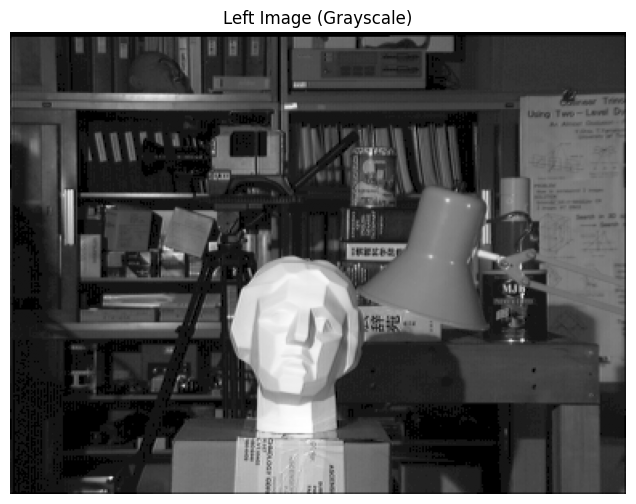

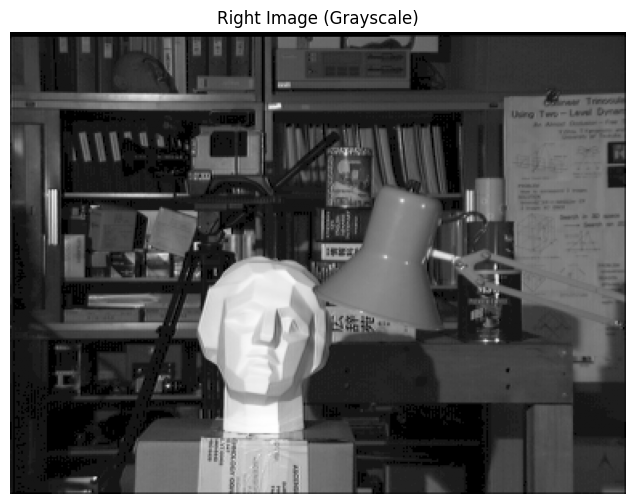

In [8]:
# OpenCVを使う準備
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(8, 6))
    if len(img.shape) == 3:
        # カラー画像の場合、BGR→RGB変換
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    else:
        # グレースケール画像の場合
        plt.imshow(img, cmap='gray' if cmap is None else cmap)
    plt.title(title)
    plt.axis('off')
    plt.show()

imgL = cv2.imread(image_filename1, cv2.IMREAD_GRAYSCALE)
imgR = cv2.imread(image_filename2, cv2.IMREAD_GRAYSCALE)
show_image(imgL, "Left Image (Grayscale)")
show_image(imgR, "Right Image (Grayscale)")

## ブロックマッチング法
ステレオ画像から奥行分布を導出する関数としてStereoBM_createがあります。引数にはnumDisparitiesとblockSizeとがあります。numDisparitiesは奥行値を推定するとき、ステレオ画像をずらす画素数を指定します。このnumDisparitiesよりも大きいズレ幅があると、ステレオ対応がうまく導出されません。numDisparitiesに大きな値を指定すると、手前の物体まで奥行き値を推定します。もう一つの引数blockSizeはブロックの大きさを指定します。blockSizeに小さい値を指定すると細かい領域の奥行き値を求め、大きい値にするとまとまった領域の奥行き値を求めます。

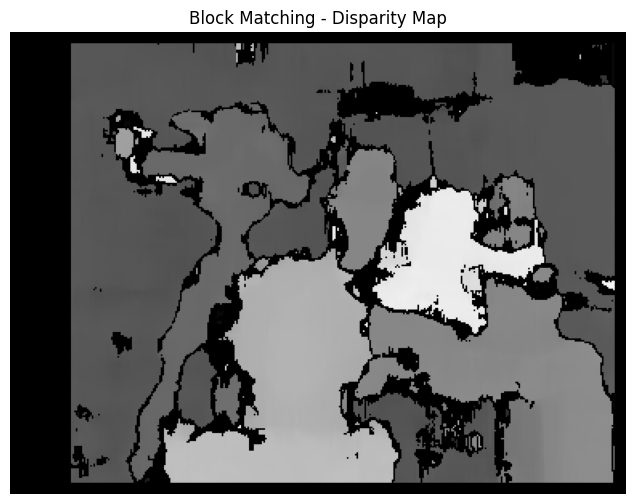

In [9]:
# Block Matching Method

stereo = cv2.StereoBM_create(numDisparities=32, blockSize=15)
disparity = stereo.compute(imgL,imgR)

show_image(disparity, "Block Matching - Disparity Map", cmap='gray')

## セミグローバル・ブロックマッチング法
視差を導出する際にコスト関数を設定し、最適な視差を求めるプロセスを導入しています。

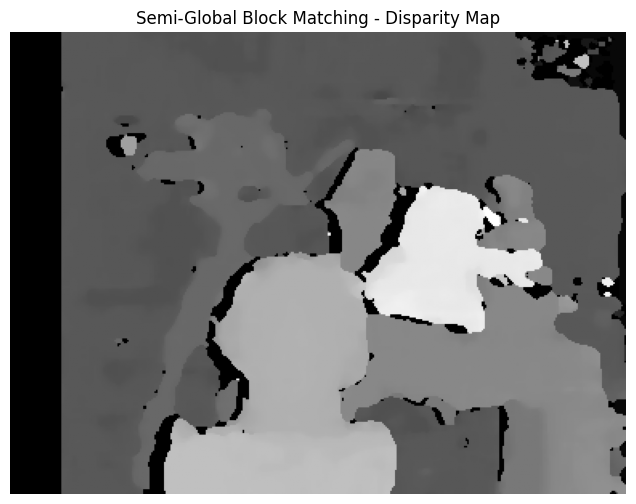

In [10]:
# Semi-Global Block Matching Method

# disparity range is tuned for 'aloe' image pair
window_size = 3
min_disp = 0
num_disp = 32 - min_disp
stereo = cv2.StereoSGBM_create(
    minDisparity = min_disp,            # 視差の最小値
    numDisparities = num_disp,          # 視差の範囲
    blockSize = 11,                     # ブロックサイズ
    P1 = 8*3*window_size**2,            # 視差の滑らかさを制御
    P2 = 32*3*window_size**2,           # 視差の滑らかさを制御
    disp12MaxDiff = 1,                  # 左と右との視差を確認する際に許容される最大の差
    uniquenessRatio = 10,               # 導出された視差が最も適正であると判断するための2番目によい値とのマージン
    speckleWindowSize = 100,            # 滑らかな視差領域の最大サイズ
    speckleRange = 32                   # 連結成分における視差変動の最大値
)
disparity = stereo.compute(imgL,imgR)

show_image(disparity, "Semi-Global Block Matching - Disparity Map", cmap='gray')

# カメラキャリブレーション
上に示したステレオ画像から奥行分布を導出するには、カメラの内部パラメータがわかっていないといけません。そこで、カメラパラメータとレンズひずみを求めます。まず、以下からチェッカーパターンを複数の視点から撮影したカメラ画像をダウンロードします。

ご自身のカメラのカメラパラメータを導出したいなら、そのカメラでチェッカーパターンを撮影し、そのカメラ画像のファイルをアップロードします。カメラキャリブレーションに使うチェッカーパターンはOpenCVのWebサイトで提供されています。以下からダウンロードして下さい（[チェッカーパターン](http://opencv.jp/sample/pics/chesspattern_7x10.pdf)）。

## カメラ画像の準備
カメラでチェッカーパターンを撮影した画像を幾つか用意します。本来は使用するカメラで撮った画像じゃないと意味がないのですが、ここではプログラムの動作を確認するために、一連の画像ファイルを以下のGitHubのWebサイトから取得して下さい。
- [image files](https://github.com/opencv/opencv/tree/master/samples/data)

ダウンロードするのは、left01.jpg, left02.jpg, ..., left14.jpgという一連の画像ファイルです。ダウンロードしたファイルを、今度はご自身のGoogle Colaboratoryにアップロードします。左側のサイドバーで「フォルダ」アイコンをクリックし、そこに一連の画像ファイルをドラッグ＆ドロップして下さい。

globモジュールについて簡単に説明しておきます。globモジュールのglob関数は、条件に一致するファイルを取得するものです。ファイルの一致条件を引数として与えると、その条件に一致したファイルを返してくれます。

In [ ]:
# カメラキャリブレーション用の画像設定
# cv_ex09フォルダ内の画像を使用
import glob
images = glob.glob('cv_ex09/left*.jpg')
images.sort()  # ファイル名順にソート
print("使用する画像数:", len(images))
print("画像ファイル:", images[:5], "...")  # 最初の5つを表示

# 最初の2つの画像を表示
if len(images) >= 2:
    img01 = cv2.imread(images[0])
    img02 = cv2.imread(images[1])
    show_image(img01, f"Calibration Image: {images[0]}")
    show_image(img02, f"Calibration Image: {images[1]}")

## カメラの内部パラメータの算出
まず、カメラの内部パラメータを算出します。

In [ ]:
# Camera calibration using multiple images from cv_ex09 folder
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# チェスボードの設定
cbrow = 9  # 横方向のコーナー数
cbcol = 6  # 縦方向のコーナー数

# チェスボードのワールド座標を準備
objp = np.zeros((cbcol*cbrow, 3), np.float32)
objp[:,:2] = np.mgrid[0:cbrow, 0:cbcol].T.reshape(-1, 2)

# 検出されたコーナーの座標を格納するリスト
objpoints = []  # 3D点
imgpoints = []  # 2D点

# cv_ex09フォルダ内のすべての画像を処理
for fname in images:
    img = cv2.imread(fname)
    if img is None:
        print(f"Could not load {fname}")
        continue
        
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # チェスボードのコーナー検出
    ret, corners = cv2.findChessboardCorners(gray, (cbrow, cbcol), None)
    
    if ret == True:
        print(f"✓ Chessboard corners found in {fname}")
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        
        # 最初の画像のみコーナーを描画して表示
        if fname == images[0]:
            img = cv2.drawChessboardCorners(img, (cbrow, cbcol), corners2, ret)
            show_image(img, f"Chessboard Corners Detected - {fname}")
    else:
        print(f"✗ No chessboard pattern found in {fname}")

print(f"\n成功した画像数: {len(objpoints)}/{len(images)}")

## 内部パラメータの計算
次に内部パラメータを計算します。

In [ ]:
# 内部パラメータの計算
if len(objpoints) > 0:
    # 画像サイズ（最後に処理した画像から取得）
    imageSize = gray.shape[::-1]
    print("画像サイズ:", imageSize)
    
    # 内部パラメータを計算（rvecs, tvecsは外部パラメータに相当）
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, imageSize, None, None)
    
    # 計算結果を保存（必要に応じて）
    # np.save("mtx", mtx)           # カメラ行列
    # np.save("dist", dist.ravel()) # 歪みパラメータ
    
    # 計算結果を表示
    print("\n=== カメラキャリブレーション結果 ===")
    print("RMS誤差:", ret)          # 誤差に相当（小さい値の方がよい）
    print("\nカメラ行列:\n", mtx)
    print("\n歪み係数:", dist.ravel())
else:
    print("エラー: チェスボードが検出された画像がありません。")

# 内部パラメータを使って画像を補正
次に内部パラメータを使って、画像を補正します。

In [ ]:
# 内部パラメータを使って画像を補正
# cv_ex09フォルダの画像を使用
if len(images) > 0 and 'mtx' in locals() and 'dist' in locals():
    targetImage = cv2.imread(images[0])  # 最初のキャリブレーション画像を使用
    if targetImage is not None:
        show_image(targetImage, f"Target Image for Correction: {images[0]}")
        
        # 歪み補正
        h, w = targetImage.shape[:2]
        newcameramtx, roi = cv2.getOptimalNewCameraMatrix(mtx, dist, (w,h), 1, (w,h))
        
        # 歪み補正を実行
        dst = cv2.undistort(targetImage, mtx, dist, None, newcameramtx)
        
        # ROIで画像をクロップ
        x, y, w, h = roi
        dst = dst[y:y+h, x:x+w]
        
        show_image(dst, "Undistorted Image")
        print("画像の歪み補正が完了しました")
    else:
        print("ターゲット画像を読み込めませんでした")
else:
    print("キャリブレーション結果がないか、画像が見つかりません")